In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.fft import fft
from scipy.fft import ifft
from scipy.signal import get_window
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('datasets/pos_A.csv', dtype={'label': str}, na_values='null', low_memory=False)

filtered_data = data[['ax', 'ay', 'az', 'label', 'animal_ID', 'timestamp_ms']]
data25 = filtered_data.iloc[::4, :].copy() #downsample 100Hz data to 25Hz data

# Calculate window index for each sample
# 10 second windows and conversion from ms to s
data25['window_index'] = data25['timestamp_ms'] // 10000

# Group data by window_index, and then split into individual windows
windows = [window for _, window in data25.groupby('window_index')]

data25.to_csv('datasets/filtered_data_25hz.csv', index=False)
del data, filtered_data #no longer need the huge data sets, free up memory to make it run faster


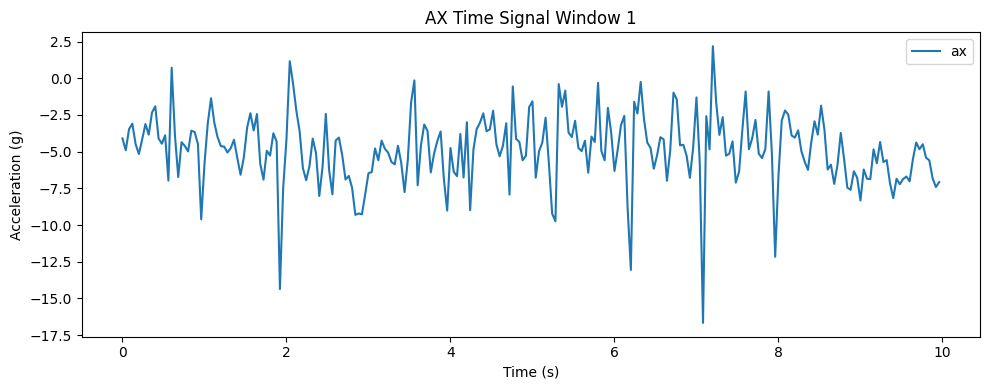

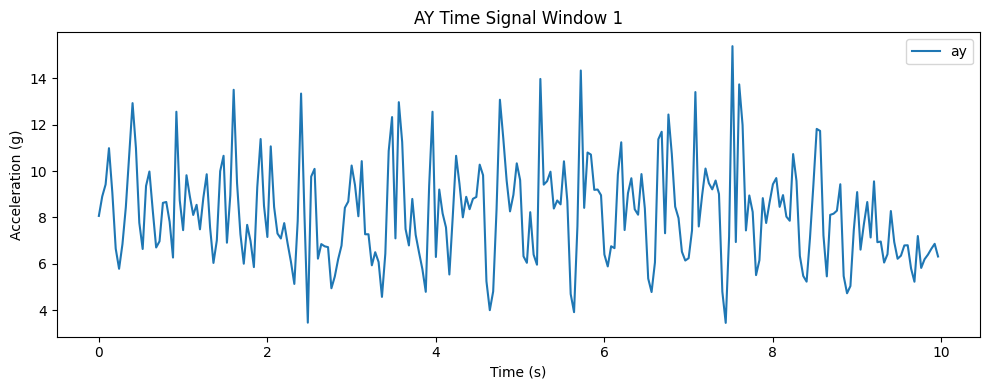

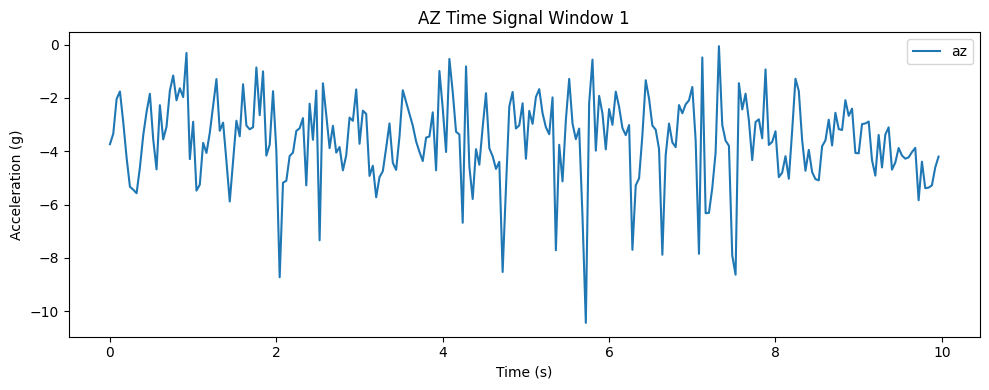

In [3]:

# Determine the number of samples per window (10 seconds * 25 Hz)
samples_per_window = 10 * 25

total_windows = len(data25) // samples_per_window


#test plot first window(s)
for axis in ['ax', 'ay', 'az']:
    for window in range(total_windows):
        if window == 0:
            start_idx = window * samples_per_window
            end_idx = start_idx + samples_per_window
            data_window = data25.iloc[start_idx:end_idx]
            
            plt.figure(figsize=(10, 4))
            plt.plot(data_window['timestamp_ms'] / 1000, data_window[axis], label=axis)
            
            # Adding title and labels
            plt.title(f'{axis.upper()} Time Signal Window {window + 1}')
            plt.xlabel('Time (s)')
            plt.ylabel('Acceleration (g)')
            plt.legend()
            plt.tight_layout()
            plt.show()


In [4]:
windows_ac = []

for window in windows:
    # Calculate DC components (mean values) for ax, ay, and az
    dc_ax = window['ax'].mean()
    dc_ay = window['ay'].mean()
    dc_az = window['az'].mean()
    
    # Calculate AC components by subtracting DC component from each signal
    window['ac_ax'] = window['ax'] - dc_ax
    window['ac_ay'] = window['ay'] - dc_ay
    window['ac_az'] = window['az'] - dc_az
    
    #other paper calculated AC components via jerk (change in subsequent measurements)
    window['jerk_ax'] = window['ax'].diff().fillna(0)
    window['jerk_ay'] = window['ay'].diff().fillna(0)
    window['jerk_az'] = window['az'].diff().fillna(0)

    
    windows_ac.append(window)



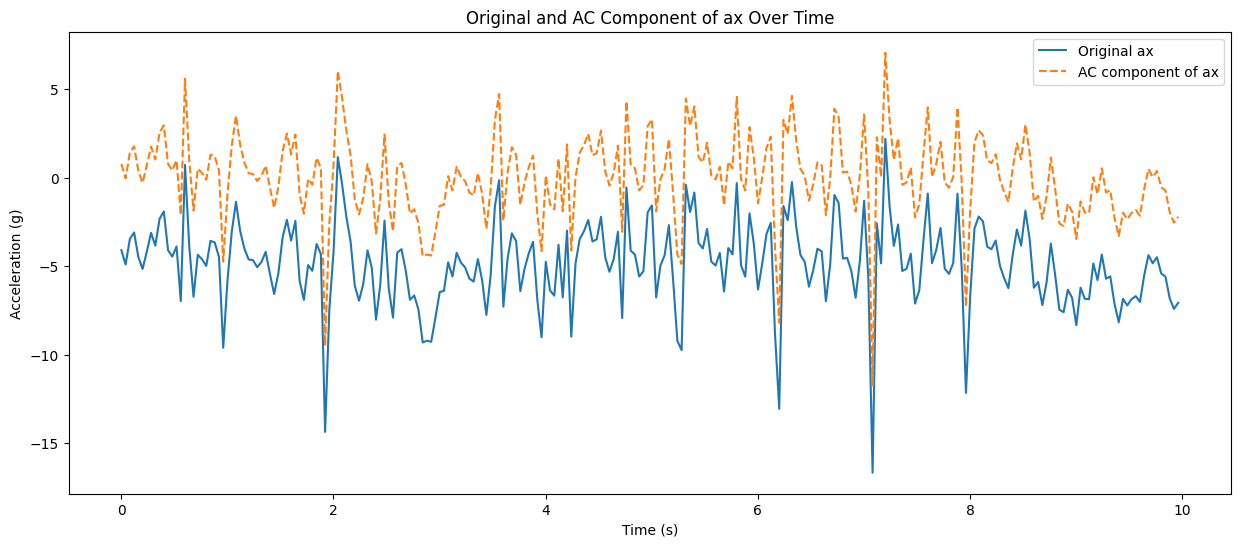

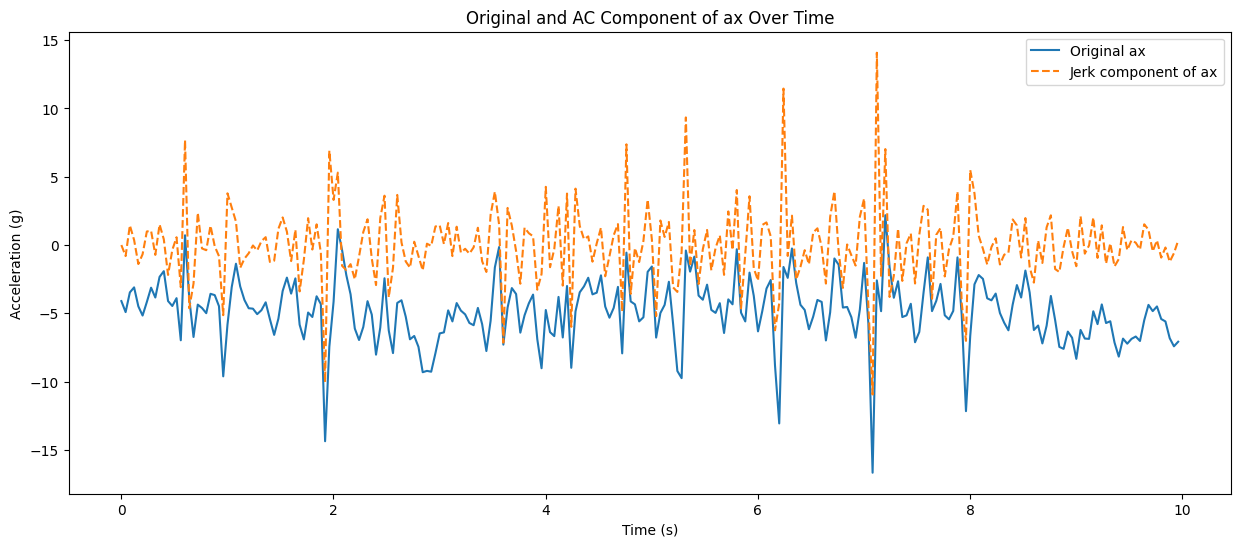

In [5]:

#plotting both AC variants to see difference
plt.figure(figsize=(15, 6))
plt.plot(windows_ac[0]['timestamp_ms'] / 1000, windows_ac[0]['ax'], label='Original ax')
plt.plot(windows_ac[0]['timestamp_ms'] / 1000, windows_ac[0]['ac_ax'], label='AC component of ax', linestyle='--')
plt.title('Original and AC Component of ax Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.legend()
plt.show()


plt.figure(figsize=(15, 6))
plt.plot(windows_ac[0]['timestamp_ms'] / 1000, windows_ac[0]['ax'], label='Original ax')
plt.plot(windows_ac[0]['timestamp_ms'] / 1000, windows_ac[0]['jerk_ax'], label='Jerk component of ax', linestyle='--')
plt.title('Original and AC Component of ax Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.legend()
plt.show()



1. Divide the AC component into 1-second windows: Since your data is sampled at 25 Hz, a 1-second window will contain 25 samples.

2. Apply the Hanning window function: This is a windowing function used to reduce the spectral leakage before performing the FFT.

3. Compute the FFT for each window: Perform the FFT on each windowed segment of the AC component.

4. Handle 50% overlap: When moving to the next window, you start at the halfway point of the current window, which means each window will overlap the previous one by 50%.

In [6]:
def process_window(windows_ac, windowID=None):
    sampling_rate = 25  # 25 Hz sampling rate
    window_size = sampling_rate  # 1-second window for 1 Hz resolution
    overlap = window_size // 2  # 50% overlap
    hann_window = get_window('hann', window_size)
    
    # Initialize structure to store time domain signals
    all_time_domain_signals = {}
    
    # Determine which windows and axes to process
    axes_to_process = ['ax'] if windowID is not None else ['ax', 'ay', 'az']
    window_indices = [windowID] if windowID is not None else range(len(windows_ac))
    
    for axis in axes_to_process:
        all_time_domain_signals[axis] = {}
        
        for ID in window_indices:
            # Initialize frequency bands for the current window and axis
            all_time_domain_signals[axis][ID] = {f: [] for f in range(6)}
            window_data = windows_ac[ID][f'jerk_{axis}'].to_numpy()
            
            for i in range(0, len(window_data) - window_size + 1, overlap):
                window_segment = window_data[i:i+window_size] * hann_window
                fft_result = fft(window_segment, n=window_size)
                
                for f in range(6):
                    isolated_fft = np.zeros_like(fft_result)
                    isolated_fft[f] = fft_result[f]
                    time_signal = ifft(isolated_fft, n=window_size).real
                    all_time_domain_signals[axis][ID][f].append(time_signal[:window_size])

            # Concatenate overlapping windows for each frequency band
            for f in all_time_domain_signals[axis][ID]:
                concatenated_signal = [all_time_domain_signals[axis][ID][f][0]]
                for segment in all_time_domain_signals[axis][ID][f][1:]:
                    concatenated_signal.append(segment[overlap:])
                all_time_domain_signals[axis][ID][f] = np.concatenate(concatenated_signal)
            
            if windowID is not None and axis == 'ax':
                # Plot only for the X-axis if windowID is provided
                plot_signals(all_time_domain_signals[axis][windowID], windowID, axis)
    
    # If no specific windowID is provided, all_time_domain_signals contains all axes for all windows
    return all_time_domain_signals

def plot_signals(time_domain_signals, windowID, axis):
    time_vector = np.linspace(0, 10, num=len(time_domain_signals[0]), endpoint=False)
    plt.figure(figsize=(15, 6))
    for f in range(6):
        plt.plot(time_vector + 10*windowID, time_domain_signals[f], label=f'{f} Hz Band')
    plt.title(f'Spectral Components for {axis.upper()} ({windowID*10} to {windowID*10 + 10} seconds)')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (g)')
    plt.legend()
    plt.show()
        # subplots,  one for each frequency band
    num_bands = 6
    fig, axes = plt.subplots(num_bands, 1, figsize=(15, 2*num_bands))
    time_vector = np.linspace(0, 10, num=len(time_domain_signals[0]), endpoint=False)
    for f in range(num_bands):
        ax = axes[f] if num_bands > 1 else axes
        ax.plot(time_vector + windowID*10, time_domain_signals[f], label=f'{f} Hz Band')  
        ax.set_title(f'Frequency Band {f} Hz')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude (g)')
        ax.legend()
    plt.tight_layout()
    plt.show()
    


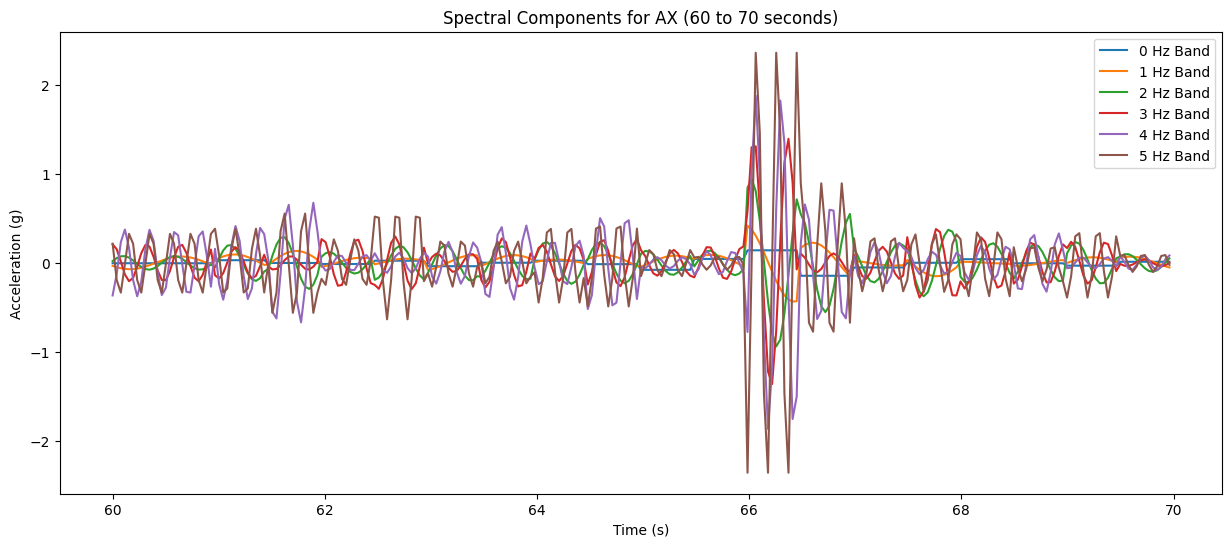

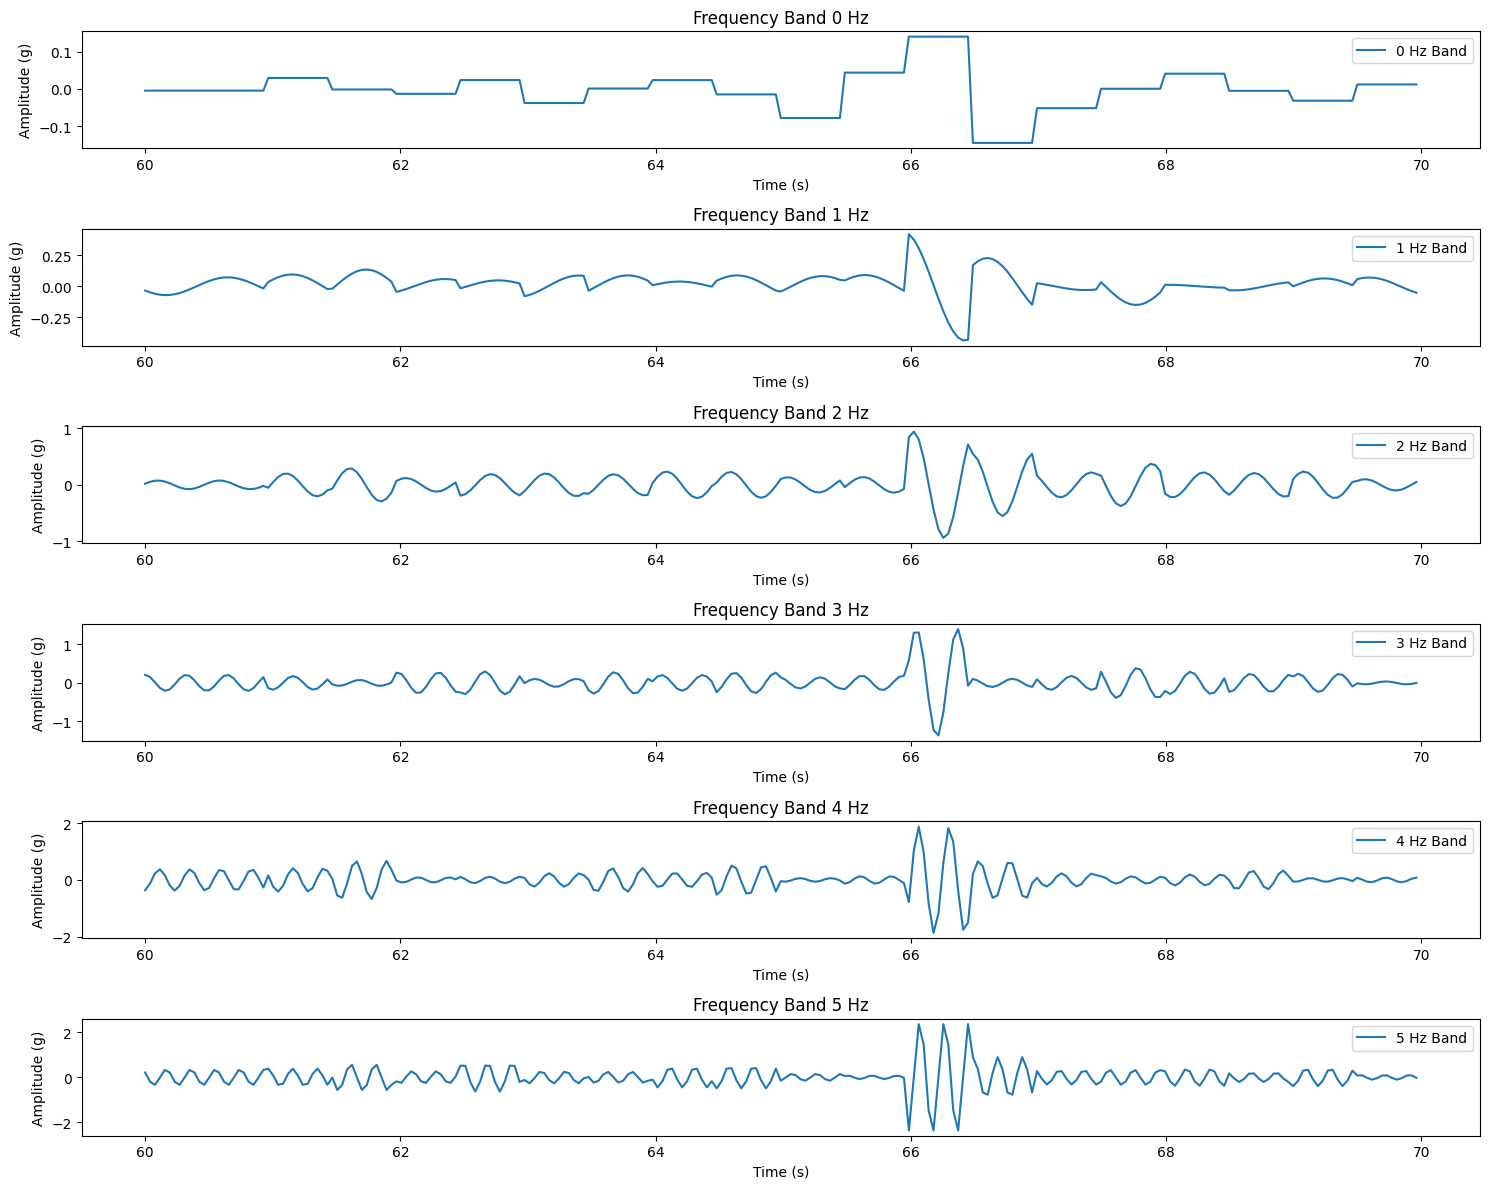

In [9]:
windowID = 6 # Set to None to process all windows, or to a specific ID to process just that window and plot (for the x-axis)

if windowID is not None:
    process_window(windows_ac, windowID) 
else:
    all_time_domain_signals = process_window(windows_ac)